# Random Forest + Isolation Forest + Class 5 in training

✅ Shape dataset: (263, 21)
✅ Valori zero nelle features: 522
✅ Clipping applicato (soglia 15)
✅ Train shape: (168, 20) | Val: (42, 20) | Test: (53, 20)

📊 Distribuzione classi in Train:
Classe 1: 30 campioni
Classe 2: 35 campioni
Classe 3: 32 campioni
Classe 4: 37 campioni
Classe 5: 34 campioni

📊 Distribuzione classi in Validation:
Classe 1: 8 campioni
Classe 2: 9 campioni
Classe 3: 8 campioni
Classe 4: 9 campioni
Classe 5: 8 campioni

📊 Distribuzione classi in Test:
Classe 1: 10 campioni
Classe 2: 11 campioni
Classe 3: 10 campioni
Classe 4: 11 campioni
Classe 5: 11 campioni

🔍 Cross-validation acc: [0.64705882 0.67647059 0.79411765 0.60606061 0.72727273]
Media: 0.6902 | Std: 0.0653

🔍 Tuning soglia probabilità (validation set):
Soglia: 0.30 | Weighted F1: 0.7623
Soglia: 0.35 | Weighted F1: 0.7599
Soglia: 0.40 | Weighted F1: 0.7387
Soglia: 0.45 | Weighted F1: 0.7516
Soglia: 0.50 | Weighted F1: 0.6911
Soglia: 0.55 | Weighted F1: 0.6119
Soglia: 0.60 | Weighted F1: 0.5155
Soglia: 0.65 | 

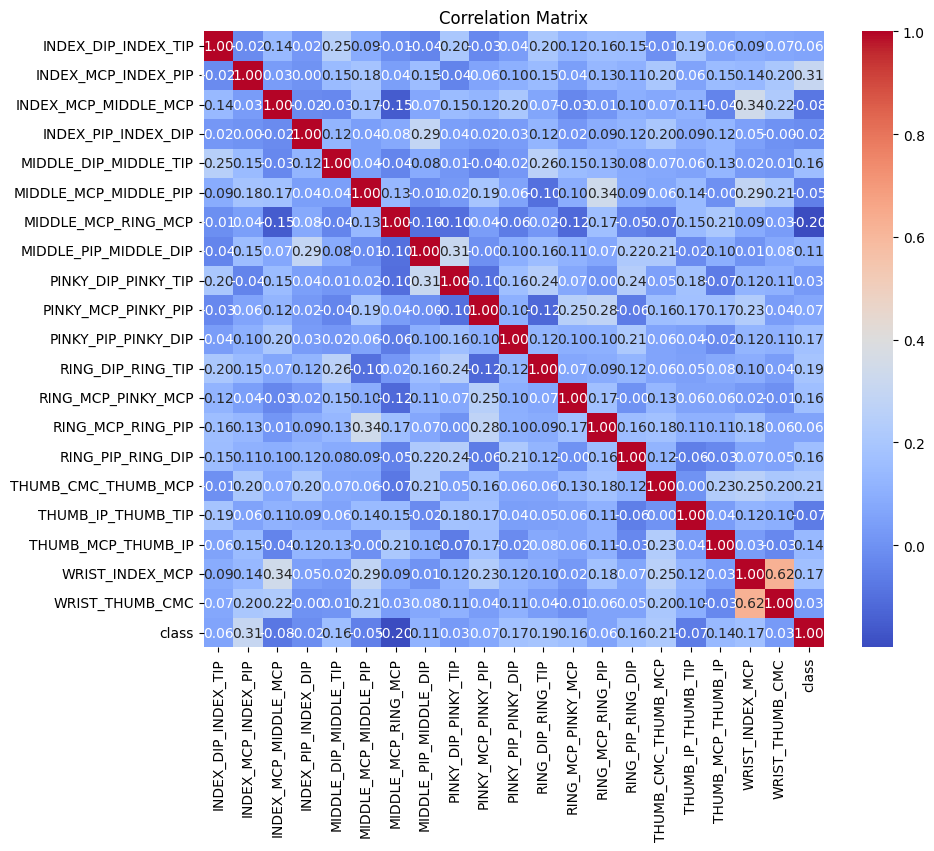

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, f1_score
from collections import Counter
import csv

# 1. Caricamento dataset
dataset = pd.read_csv('./distanze_aggregated_con_classe.csv')
dataset = dataset.drop(['frame_id'], axis=1)

print(f"Shape dataset: {dataset.shape}")
print(f"Valori zero nelle features: {((dataset.drop(['class'], axis=1) == 0).sum()).sum()}")

# 2. Preprocessing (clipping)
feature_columns = dataset.columns.drop('class')
dataset[feature_columns] = dataset[feature_columns].clip(upper=15)
print("Clipping applicato (soglia 15)")

# 3. Feature + target split
X = dataset.drop(['class'], axis=1)
y = dataset['class']

# 4. Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Suddivisione Train/Val/Test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

print(f"Train shape: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")

# 6. Distribuzione classi in ogni split
def print_class_distribution(y, split_name):
    dist = Counter(y)
    print(f"\n Distribuzione classi in {split_name}:")
    for cls, count in sorted(dist.items()):
        print(f"Classe {cls}: {count} campioni")

print_class_distribution(y_train, "Train")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")

# 7. Random Forest con calibrazione
base_clf = RandomForestClassifier(n_estimators=100, random_state=42)
calibrated_clf = CalibratedClassifierCV(estimator=base_clf, method='sigmoid', cv=5)

# 8. Cross-validation preliminare
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(base_clf, X_train, y_train, cv=kf, scoring='accuracy')
print(f"\n🔍 Cross-validation acc: {cv_scores}")
print(f"Media: {np.mean(cv_scores):.4f} | Std: {np.std(cv_scores):.4f}")

# 9. Fit modello calibrato
calibrated_clf.fit(X_train, y_train)

# 10. Tuning soglia probabilità su validation set
val_probs = calibrated_clf.predict_proba(X_val)
val_preds = calibrated_clf.predict(X_val)
max_probs_val = np.max(val_probs, axis=1)

best_thresh = None
best_f1 = 0

print("\n🔍 Tuning soglia probabilità (validation set):")
for thresh in np.arange(0.3, 0.95, 0.05):
    final_preds_val = [5 if prob < thresh else pred for pred, prob in zip(val_preds, max_probs_val)]
    f1 = f1_score(y_val, final_preds_val, average='weighted', zero_division=0)
    print(f"Soglia: {thresh:.2f} | Weighted F1: {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"\n Soglia probabilità ottimale: {best_thresh:.2f} con F1-score: {best_f1:.4f}")

# 11. Isolation Forest tuning su validation set
best_contam = None
best_f1_outlier = 0

print("\n Tuning Isolation Forest (validation set):")
for contam in [0.01, 0.025, 0.05, 0.075, 0.1]:
    iso_forest = IsolationForest(contamination=contam, random_state=42)
    iso_forest.fit(X_train)
    iso_preds_val = iso_forest.predict(X_val)

    final_preds_val = []
    for i in range(len(X_val)):
        if iso_preds_val[i] == -1 or max_probs_val[i] < best_thresh:
            final_preds_val.append(5)
        else:
            final_preds_val.append(val_preds[i])

    f1 = f1_score(y_val, final_preds_val, average='weighted', zero_division=0)
    print(f"Contamination: {contam:.3f} | Weighted F1: {f1:.4f}")
    if f1 > best_f1_outlier:
        best_f1_outlier = f1
        best_contam = contam

print(f"\n Contamination ottimale: {best_contam:.3f} con F1: {best_f1_outlier:.4f}")

# 12. Isolation Forest finale
iso_forest = IsolationForest(contamination=best_contam, random_state=42)
iso_forest.fit(X_train)

# 13. Inferenza su Test set
test_probs = calibrated_clf.predict_proba(X_test)
test_preds = calibrated_clf.predict(X_test)
max_probs_test = np.max(test_probs, axis=1)
iso_preds_test = iso_forest.predict(X_test)

final_preds_test = []
for i in range(len(X_test)):
    if iso_preds_test[i] == -1 or max_probs_test[i] < best_thresh:
        final_preds_test.append(5)
    else:
        final_preds_test.append(test_preds[i])

# 14. Report Finale
print("\n Report finale RandomForest + IsolationForest (Test set):")
print(classification_report(y_test, final_preds_test, zero_division=0))

# 15. Dettaglio scarti nel Test set
scarti_veri = sum(y_test == 5)
scarti_predetti = final_preds_test.count(5)

print(f"\n Dettaglio classe 5 (scarto):")
print(f"Presenti nel Test set: {scarti_veri}")
print(f"Predetti come 'scarto': {scarti_predetti}")

# 16. Salvataggio risultati CSV
output_path = '/predictions_calibrated_outlier.csv'
with open(output_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Index', 'Ground Truth', 'Predicted', 'Max Probabilità', 'IsolationForest Flag'])
    for i in range(len(y_test)):
        writer.writerow([i, y_test.iloc[i], final_preds_test[i], max_probs_test[i], iso_preds_test[i]])

print(f"\n CSV salvato: {output_path}")

from sklearn.metrics import precision_score, recall_score, f1_score

print("\n Valutazione manuale sulla classe 5 (scarto):")
precision_5 = precision_score(y_test, final_preds_test, labels=[5], average='macro', zero_division=0)
recall_5 = recall_score(y_test, final_preds_test, labels=[5], average='macro', zero_division=0)
f1_5 = f1_score(y_test, final_preds_test, labels=[5], average='macro', zero_division=0)

print(f"Precision Classe 5 (scarto): {precision_5:.4f}")
print(f"Recall Classe 5 (scarto):    {recall_5:.4f}")
print(f"F1-score Classe 5 (scarto):  {f1_5:.4f}")

import collections

# Estrai gli indici delle predizioni che sono finite in classe 5
scarti_idx = [i for i, pred in enumerate(final_preds_test) if pred == 5]

# Ottieni le vere etichette (y_test) corrispondenti agli scarti
true_labels_scartati = y_test.iloc[scarti_idx].values

# Conta quante vere etichette sono state scartate
scarto_counter = collections.Counter(true_labels_scartati)

print("\n Analisi dei frame scartati (predetti come classe 5):")
print(f" - Totale scartati: {len(scarti_idx)}")
for cls in sorted(scarto_counter.keys()):
    print(f"   → Classe {cls}: {scarto_counter[cls]} scartati")

    # 1. Costruisci il DataFrame
df_if = pd.DataFrame({
    'Index':                np.arange(len(y_test)),
    'Ground Truth':         y_test.values,
    'Predicted':            final_preds_test,
    'Max Probability':      max_probs_test,
    'IsolationForest Flag': iso_preds_test
})

# 2. Salva come CSV senza l’indice pandas
output_path = 'predictions_calibrated_outlier.csv'
df_if.to_csv(output_path, index=False)

print(f" File salvato: {output_path}")

!pip install -q joblib

import joblib
from google.colab import files

# 17. Salvataggio dei modelli e dello scaler
# -------------------------------------------------
# Modello Random Forest calibrato
joblib.dump(calibrated_clf, 'calibrated_rf_model.pkl')
print(" Modello Random Forest calibrato salvato in: calibrated_rf_model.pkl")

# Modello Isolation Forest
joblib.dump(iso_forest, 'isolation_forest_model.pkl')
print("✅ Modello Isolation Forest salvato in: isolation_forest_model.pkl")

# (Opzionale) Salvataggio dello scaler per ripreprocessing coerente
joblib.dump(scaler, 'scaler.pkl')
print("✅ Scaler salvato in: scaler.pkl")

# 18. (Opzionale) Download diretto su locale
files.download('calibrated_rf_model.pkl')
files.download('isolation_forest_model.pkl')
files.download('scaler.pkl')


# correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = dataset.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Random Forest + Isolation Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from collections import Counter

# Utility per stampare le distribuzioni di classe
def print_class_distribution(y_split, split_name):
    dist = Counter(y_split)
    print(f"\n Distribuzione classi in {split_name}:")
    for cls, count in sorted(dist.items()):
        print(f"  Classe {cls}: {count} campioni")


# 1. Caricamento dataset
dataset = pd.read_csv('./distanze_aggregated_con_classe.csv').drop(columns=['frame_id'])
print(f" Shape dataset: {dataset.shape}")
print(f" Valori zero nelle features: {(dataset.drop(columns='class') == 0).sum().sum()}")

# 2. Preprocessing (clipping)
feature_columns = dataset.columns.drop('class')
dataset[feature_columns] = dataset[feature_columns].clip(upper=15)
print(" Clipping applicato (soglia 15)")

# 3. Feature + target split
X = dataset.drop(columns='class')
y = dataset['class']

# 4. Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Separa classe 5 da tutte le altre
mask5    = (y == 5)
X_cls5   = X_scaled[mask5.values]
y_cls5   = y[mask5].values
X_rest   = X_scaled[~mask5.values]
y_rest   = y[~mask5].values

# 6. Split (classi 1–4) in train+val vs test_rest (20%)
X_trainval_rest, X_test_rest, y_trainval_rest, y_test_rest = train_test_split(
    X_rest, y_rest,
    test_size=0.2,
    stratify=y_rest,
    random_state=42
)

# 7. Costruisci il test set includendo TUTTA classe 5
X_test = np.vstack([X_test_rest, X_cls5])
y_test = np.concatenate([y_test_rest, y_cls5])

# 8. Suddividi train+val (classi 1–4) in train vs validation
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval_rest, y_trainval_rest,
    test_size=0.2,
    stratify=y_trainval_rest,
    random_state=42
)

print_class_distribution(y_train, "Train")
print_class_distribution(y_val,   "Validation")
print_class_distribution(y_test,  "Test")

# 9. Random Forest con calibrazione
base_clf        = RandomForestClassifier(n_estimators=100, random_state=42)
calibrated_clf  = CalibratedClassifierCV(estimator=base_clf, method='sigmoid', cv=5)

# 10. Cross-validation preliminare
kf        = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(base_clf, X_train, y_train, cv=kf, scoring='accuracy')
print(f"\n Cross-validation acc: {cv_scores}")
print(f"Media: {np.mean(cv_scores):.4f} | Std: {np.std(cv_scores):.4f}")

# 11. Fit modello calibrato
calibrated_clf.fit(X_train, y_train)

# 12. Tuning soglia probabilità su validation set
val_probs    = calibrated_clf.predict_proba(X_val)
val_preds    = calibrated_clf.predict(X_val)
max_probs_val = np.max(val_probs, axis=1)

best_thresh = 0.0
best_f1     = 0.0
print("\n Tuning soglia probabilità (validation set):")
for thresh in np.arange(0.3, 0.95, 0.05):
    final_preds_val = [
        5 if prob < thresh else pred
        for pred, prob in zip(val_preds, max_probs_val)
    ]
    f1 = f1_score(y_val, final_preds_val, average='weighted', zero_division=0)
    print(f"  Soglia {thresh:.2f} → F1-weighted: {f1:.4f}")
    if f1 > best_f1:
        best_f1     = f1
        best_thresh = thresh

print(f"\n Soglia probabilità ottimale: {best_thresh:.2f} (F1={best_f1:.4f})")

# 13. Tuning Isolation Forest su validation set
best_contam     = 0.0
best_f1_outlier = 0.0
print("\n Tuning Isolation Forest (validation set):")
for contam in [0.01, 0.025, 0.05, 0.075, 0.1]:
    iso_tmp = IsolationForest(contamination=contam, random_state=42)
    iso_tmp.fit(X_train)
    iso_preds_val = iso_tmp.predict(X_val)

    final_preds_val = [
        5 if (iso_preds_val[i] == -1 or max_probs_val[i] < best_thresh)
        else val_preds[i]
        for i in range(len(X_val))
    ]
    f1 = f1_score(y_val, final_preds_val, average='weighted', zero_division=0)
    print(f"  Contamination {contam:.3f} → F1-weighted: {f1:.4f}")
    if f1 > best_f1_outlier:
        best_f1_outlier = f1
        best_contam     = contam

print(f"\n Contamination ottimale: {best_contam:.3f} (F1={best_f1_outlier:.4f})")

# 14. Isolation Forest finale
iso_forest = IsolationForest(contamination=best_contam, random_state=42)
iso_forest.fit(X_train)

# 15. Inferenza su Test set
test_probs      = calibrated_clf.predict_proba(X_test)
test_preds      = calibrated_clf.predict(X_test)
max_probs_test  = np.max(test_probs, axis=1)
iso_preds_test  = iso_forest.predict(X_test)

final_preds_test = [
    5 if (iso_preds_test[i] == -1 or max_probs_test[i] < best_thresh)
    else test_preds[i]
    for i in range(len(X_test))
]

# 16. Report finale
print("\n Report finale RandomForest + IsolationForest (Test set):")
print(classification_report(y_test, final_preds_test, zero_division=0))

# 17. Dettaglio su classe 5 (scarto)
precision_5 = precision_score(y_test, final_preds_test, labels=[5], average='macro', zero_division=0)
recall_5    = recall_score   (y_test, final_preds_test, labels=[5], average='macro', zero_division=0)
f1_5        = f1_score       (y_test, final_preds_test, labels=[5], average='macro', zero_division=0)

print(f"\n Precision classe 5: {precision_5:.4f}")
print(f" Recall classe 5:    {recall_5:.4f}")
print(f" F1-score classe 5:  {f1_5:.4f}")

# 18. Analisi dei frame predetti come scarto
scarti_idx            = [i for i, p in enumerate(final_preds_test) if p == 5]
true_labels_scartati  = y_test[scarti_idx]
scarto_counter        = Counter(true_labels_scartati)

print(f"\n Totale frame predetti come scarto: {len(scarti_idx)}")
for cls, cnt in sorted(scarto_counter.items()):
    print(f"   → Classe {cls}: {cnt} campioni")

# 19. Salvataggio risultati CSV
df_if = pd.DataFrame({
    'Index':                np.arange(len(y_test)),
    'Ground Truth':         y_test,
    'Predicted':            final_preds_test,
    'Max Probability':      max_probs_test,
    'IsolationForest Flag': iso_preds_test
})
output_path = 'predictions_calibrated_outlier.csv'
df_if.to_csv(output_path, index=False)
print(f"\n File salvato: {output_path}")

✅ Shape dataset: (263, 21)
✅ Valori zero nelle features: 522
✅ Clipping applicato (soglia 15)

📊 Distribuzione classi in Train:
  Classe 1: 30 campioni
  Classe 2: 35 campioni
  Classe 3: 32 campioni
  Classe 4: 37 campioni

📊 Distribuzione classi in Validation:
  Classe 1: 8 campioni
  Classe 2: 9 campioni
  Classe 3: 8 campioni
  Classe 4: 9 campioni

📊 Distribuzione classi in Test:
  Classe 1: 10 campioni
  Classe 2: 11 campioni
  Classe 3: 10 campioni
  Classe 4: 11 campioni
  Classe 5: 53 campioni

🔍 Cross-validation acc: [0.85185185 0.88888889 0.62962963 0.7037037  0.76923077]
Media: 0.7687 | Std: 0.0948

🔍 Tuning soglia probabilità (validation set):
  Soglia 0.30 → F1-weighted: 0.7896
  Soglia 0.35 → F1-weighted: 0.8013
  Soglia 0.40 → F1-weighted: 0.7924
  Soglia 0.45 → F1-weighted: 0.8036
  Soglia 0.50 → F1-weighted: 0.8036
  Soglia 0.55 → F1-weighted: 0.7855
  Soglia 0.60 → F1-weighted: 0.7053
  Soglia 0.65 → F1-weighted: 0.6209
  Soglia 0.70 → F1-weighted: 0.5747
  Soglia 0.

# Random Forest + Classe 5 in Training

CV accuracy: [0.64705882 0.67647059 0.79411765 0.60606061 0.72727273]
Mean: 0.6902 | Std: 0.0653
Optimal threshold: 0.30 → F1-weighted: 0.7623

=== Classification Report (RF + Calibration) ===
              precision    recall  f1-score   support

           1       1.00      0.70      0.82        10
           2       0.77      0.91      0.83        11
           3       0.90      0.90      0.90        10
           4       0.82      0.82      0.82        11
           5       0.83      0.91      0.87        11

    accuracy                           0.85        53
   macro avg       0.86      0.85      0.85        53
weighted avg       0.86      0.85      0.85        53

Classe 5 – Precision: 0.8333, Recall: 0.9091, F1: 0.8696
✅ predictions_calibrated_only.csv salvato.
✅ Modello Random Forest calibrato salvato in: calibrated_rf_model.pkl
✅ Scaler salvato in: scaler.pkl
Mean: [ 6.70594914  9.5803468   7.76924935  7.285154    7.16509721 10.46290592
  7.47652803  8.28832541  5.04474619 

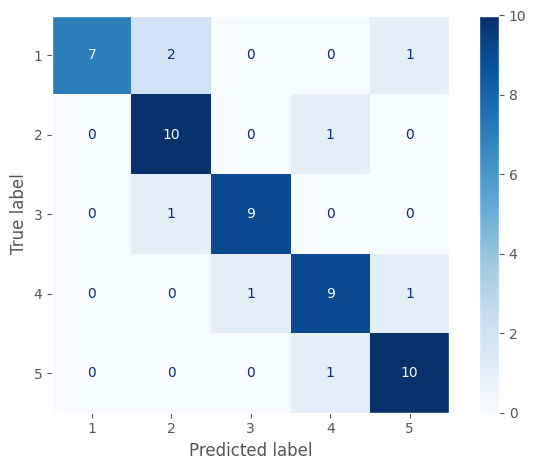

  0%|          | 0/53 [00:00<?, ?it/s]

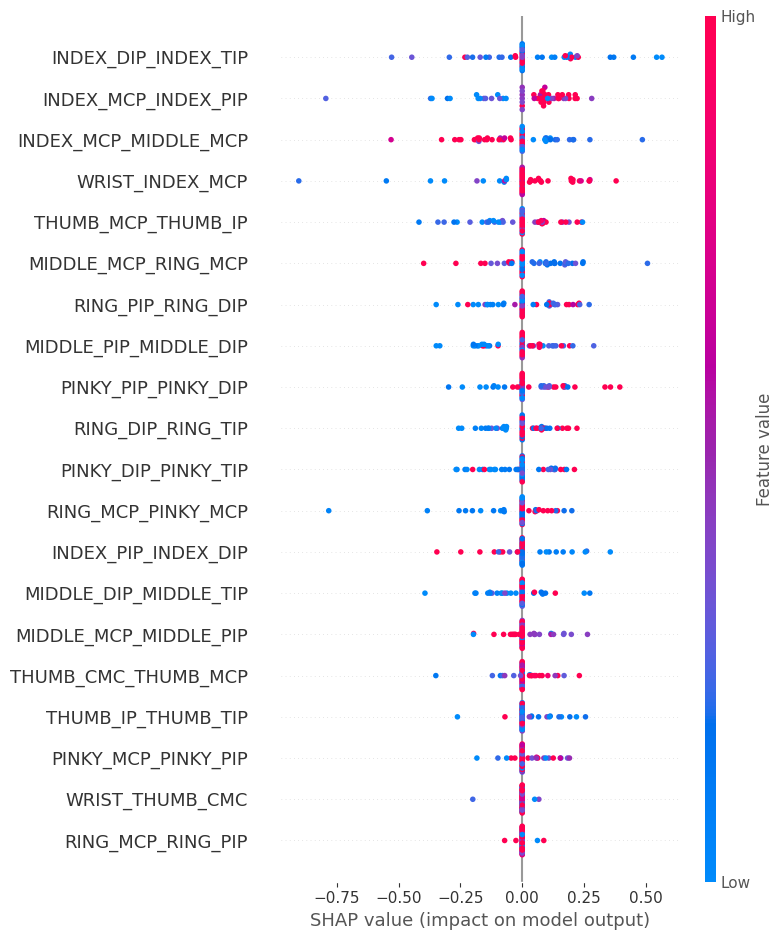

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from collections import Counter
import csv
import matplotlib.pyplot as plt
import shap
import joblib
from google.colab import files


# 1. Caricamento dataset
dataset = pd.read_csv('./distanze_aggregated_con_classe.csv')
dataset = dataset.drop(['frame_id'], axis=1)

# 2. Preprocessing (clipping)
feature_columns = dataset.columns.drop('class')
dataset[feature_columns] = dataset[feature_columns].clip(upper=15)

# 3. Feature + target split
X = dataset.drop(['class'], axis=1)
y = dataset['class']

# 4. Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Suddivisione Train/Val/Test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# 6. Cross-validation preliminare sul training set
base_clf = RandomForestClassifier(n_estimators=100, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(base_clf, X_train, y_train, cv=kf, scoring='accuracy')
print(f"CV accuracy: {cv_scores}")
print(f"Mean: {np.mean(cv_scores):.4f} | Std: {np.std(cv_scores):.4f}")

# 7. Calibrazione
calibrated_clf = CalibratedClassifierCV(estimator=base_clf, method='sigmoid', cv=5)
calibrated_clf.fit(X_train, y_train)

# 8. Tuning soglia probabilità su validation set
val_probs = calibrated_clf.predict_proba(X_val)
val_preds = calibrated_clf.predict(X_val)
max_probs_val = np.max(val_probs, axis=1)

best_thresh, best_f1 = 0.0, 0.0
for thresh in np.arange(0.3, 0.95, 0.05):
    preds = [pred if prob >= thresh else 5 for pred, prob in zip(val_preds, max_probs_val)]
    f1 = f1_score(y_val, preds, average='weighted', zero_division=0)
    if f1 > best_f1:
        best_f1, best_thresh = f1, thresh
print(f"Optimal threshold: {best_thresh:.2f} → F1-weighted: {best_f1:.4f}")

# 9. Inferenza su Test set con soglia
test_probs = calibrated_clf.predict_proba(X_test)
test_preds = calibrated_clf.predict(X_test)
max_probs_test = np.max(test_probs, axis=1)

final_preds = [pred if prob >= best_thresh else 5
               for pred, prob in zip(test_preds, max_probs_test)]

# 10. Report finale
print("\n=== Classification Report (RF + Calibration) ===")
print(classification_report(y_test, final_preds, zero_division=0))

# 11. Dettaglio classe 5 (“scarto”)
prec5 = precision_score(y_test, final_preds, labels=[5], average='macro', zero_division=0)
rec5  = recall_score(   y_test, final_preds, labels=[5], average='macro', zero_division=0)
f15   = f1_score(       y_test, final_preds, labels=[5], average='macro', zero_division=0)
print(f"Classe 5 – Precision: {prec5:.4f}, Recall: {rec5:.4f}, F1: {f15:.4f}")

# 12. Salvataggio predizioni
df_out = pd.DataFrame({
    'Index':           np.arange(len(y_test)),
    'Ground Truth':    y_test.values,
    'Predicted':       final_preds,
    'Max Probability': max_probs_test
})
df_out.to_csv('predictions_calibrated_only.csv', index=False)
print(" predictions_calibrated_only.csv salvato.")

import joblib

joblib.dump(calibrated_clf, "calibrated_rf_model.pkl")
print(" Modello Random Forest calibrato salvato in: calibrated_rf_model.pkl")

joblib.dump(scaler, "scaler.pkl")
print(" Scaler salvato in: scaler.pkl")

print("Mean:", scaler.mean_)
print("Scale:", scaler.scale_)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# costruisci la CM
cm = confusion_matrix(y_test, final_preds, labels=sorted(set(y_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=sorted(set(y_test)))

# tracci la CM
disp.plot(cmap='Blues', colorbar=True)

# disattivi la griglia (che produce le 'croci')
disp.ax_.grid(False)


plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import shap

# disattiva la griglia globale
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.facecolor'] = 'white'  # sfondo bianco

# calcola shap_values come prima
explainer = shap.KernelExplainer(calibrated_clf.predict, shap.sample(X_train, 100))
shap_values = explainer.shap_values(X_test)

# disegna il summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_columns, show=True)


# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# modello SVM
clf = SVC(kernel='rbf', C=1, gamma='scale')
clf.fit(X_train, y_train)

# valutazione
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))



# LightGBM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import LocalOutlierFactor
import lightgbm as lgb
import joblib
import csv
from sklearn.preprocessing import StandardScaler


# 1. Caricamento dataset
dataset = pd.read_csv('./distanze_aggregated_con_classe.csv')
dataset = dataset.drop(['frame_id'], axis=1)

print(f" Shape dataset: {dataset.shape}")
print(f" Valori zero nelle features: {((dataset.drop(['class'], axis=1) == 0).sum()).sum()}")

# 2. Preprocessing (clipping)
feature_columns = dataset.columns.drop('class')
dataset[feature_columns] = dataset[feature_columns].clip(upper=15)
print(" Clipping applicato (soglia 15)")

# 3. Feature + target split
X = dataset.drop(['class'], axis=1)
y = dataset['class']

# 4. Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Split train/val/test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# 4. Definizione modello LightGBM con supporto nativo NaN
lgb_clf = lgb.LGBMClassifier(
    n_estimators=200,
    random_state=42,
    reg_alpha=0.5,
    reg_lambda=0.5
)
calibrated_clf = CalibratedClassifierCV(estimator=lgb_clf, method='sigmoid', cv=5)

# 5. Cross-validation su train
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lgb_clf, X_train, y_train, cv=kf, scoring='accuracy')
print(f"\nCross-validation acc (non calibrated): {cv_scores}")
print(f"Mean acc: {np.mean(cv_scores):.4f} | Std: {np.std(cv_scores):.4f}")

# 6. Fit modello calibrato
calibrated_clf.fit(X_train, y_train)

# 7. Calcola predizioni e probabilità su validation
val_probs = calibrated_clf.predict_proba(X_val)
val_preds = calibrated_clf.predict(X_val)
max_probs_val = np.max(val_probs, axis=1)

# 8. Tuning soglia probabilità su val set (più conservativa)
best_thresh = None
best_f1 = 0
print("\n Tuning soglia probabilità (validation set):")
for thresh in np.arange(0.4, 0.95, 0.05):
    final_preds_val = []
    for p, prob in zip(val_preds, max_probs_val):
        if prob < thresh:
            final_preds_val.append(5)  # classe scarto
        else:
            final_preds_val.append(p)
    f1 = f1_score(y_val, final_preds_val, average='weighted', zero_division=0)
    print(f"Soglia: {thresh:.2f} | Weighted F1-score: {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh
print(f"\n Soglia ottimale probabilità scelta: {best_thresh:.2f} con F1-score: {best_f1:.4f}")

# 9. Outlier Detection con Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)
lof.fit(X_train)

lof_preds_val = lof.predict(X_val)  # -1 outlier, 1 inlier

# 10. Combina classificatore e LOF su val
final_preds_val = []
for i in range(len(X_val)):
    if lof_preds_val[i] == -1 or max_probs_val[i] < best_thresh:
        final_preds_val.append(5)
    else:
        final_preds_val.append(val_preds[i])

f1_combined_val = f1_score(y_val, final_preds_val, average='weighted', zero_division=0)
print(f"\nF1-weighted con LOF + soglia su validation: {f1_combined_val:.4f}")

# 11. Inferenza finale sul test set
test_probs = calibrated_clf.predict_proba(X_test)
test_preds = calibrated_clf.predict(X_test)
max_probs_test = np.max(test_probs, axis=1)
lof_preds_test = lof.predict(X_test)

final_preds_test = []
for i in range(len(X_test)):
    if lof_preds_test[i] == -1 or max_probs_test[i] < best_thresh:
        final_preds_test.append(5)
    else:
        final_preds_test.append(test_preds[i])

# 12. Report finale
print("\n Classification Report Finale (Test set con LightGBM + LOF):")
print(classification_report(y_test, final_preds_test, zero_division=0))

# 13. Salvataggio CSV risultati
output_path = '/content/predictions_lgbm_lof_nan.csv'
with open(output_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Num', 'Ground Truth', 'Predicted', 'Max Probability', 'LOF Flag'])
    for i in range(len(y_test)):
        writer.writerow([i, y_test.iloc[i], final_preds_test[i], max_probs_test[i], lof_preds_test[i]])

print(f"\n Risultati salvati in: {output_path}")

# 13. (Opzionale) Salvataggio del modello e scaler
joblib.dump(calibrated_clf, 'lgbm_calibrated_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Modello e scaler salvati come pickle")


# Grafico di Confronto tra modelli

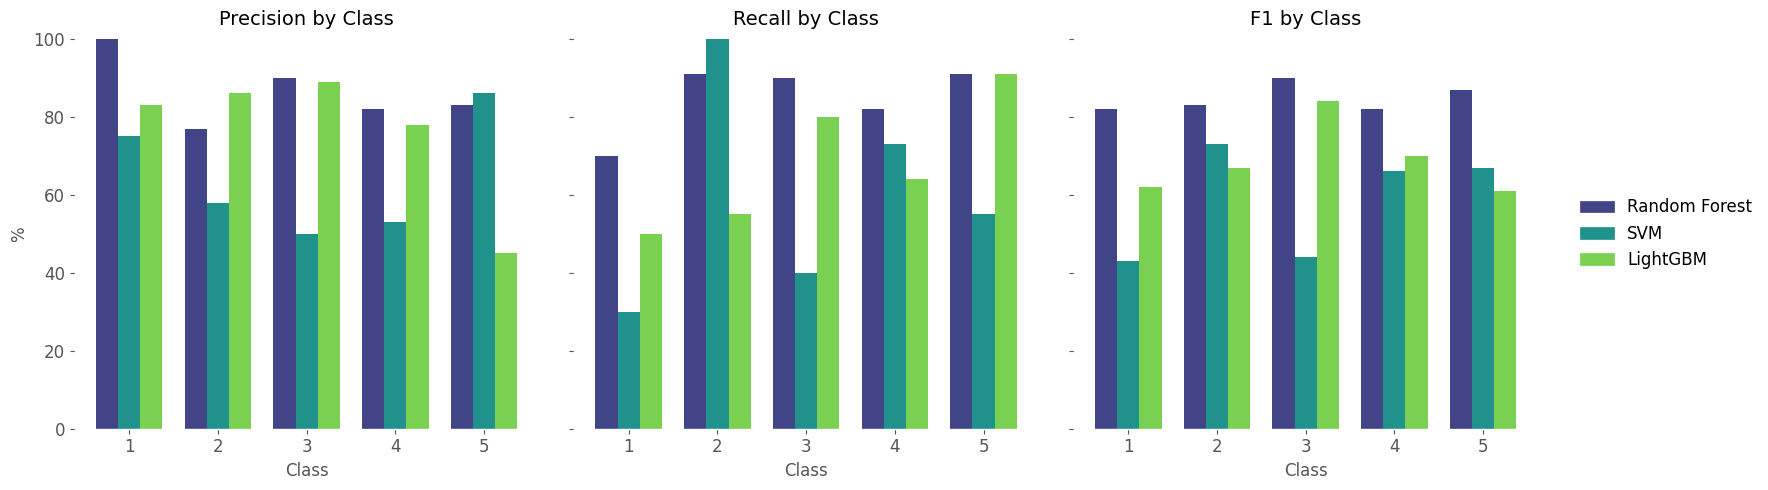

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Stile
plt.style.use('ggplot')

# Dati
data = {
    'Classe':       [1, 2, 3, 4, 5],
    'Precision_A':  [1.00, 0.77, 0.90, 0.82, 0.83],
    'Recall_A':     [0.70, 0.91, 0.90, 0.82, 0.91],
    'F1_A':         [0.82, 0.83, 0.90, 0.82, 0.87],
    'Precision_C':  [0.75, 0.58, 0.50, 0.53, 0.86],
    'Recall_C':     [0.30, 1.00, 0.40, 0.73, 0.55],
    'F1_C':         [0.43, 0.73, 0.44, 0.66, 0.67],
    'Precision_B':  [0.83, 0.86, 0.89, 0.78, 0.45],
    'Recall_B':     [0.50, 0.55, 0.80, 0.64, 0.91],
    'F1_B':         [0.62, 0.67, 0.84, 0.70, 0.61],
}

df = pd.DataFrame(data)

samples = ['A', 'C', 'B']
metrics = ['Precision', 'Recall', 'F1']
x = np.arange(len(df))
width = 0.25
legend_labels = ["Random Forest", "SVM", "LightGBM"]
# Palette
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0.2, 0.8, len(samples)))

# Crea subplot su unica riga: 3 grafici + pannello per legenda
fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=True,
                         gridspec_kw={'width_ratios': [1, 1, 1, 0.4]})
# Sfondo bianco per figura
fig.patch.set_facecolor('white')

# Disegna ciascun grafico
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    # Sfondo bianco su ciascun asse
    ax.set_facecolor('white')

    for j, sample in enumerate(samples):
        vals = df[f'{metric}_{sample}'] * 100
        offset = (j - 1) * width
        ax.bar(x + offset, vals, width, color=colors[j])
    ax.set_ylim(0, 100)
    ax.set_xticks(x)
    ax.set_xticklabels(df['Classe'], fontsize=12)
    ax.set_title(f'{metric} by Class', fontsize=14, pad=10)
    ax.set_xlabel('Class', fontsize=12)
    if idx == 0:
        ax.set_ylabel('%', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    # Rimuoviamo spigoli superflui
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)

# Pannello legenda unico, sfondo bianco
# Pannello legenda unico

axes[3].axis('off')
legend_handles = [Patch(color=colors[i], label=legend_labels[i])
                  for i in range(len(samples))]
axes[3].legend(handles=legend_handles, loc='center', frameon=False, fontsize=12)


plt.tight_layout()
plt.show()

